In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import pickle
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)


def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))
            
def load_obj(source):
    with open(source,'rb') as f:
        return pickle.load(f)

/home/llr/cms/motta/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/llr/cms/motta/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [2]:
options = {
    'v'          : '16',
    'date'       : '2023_05_28',
    'inTagIdent' : '_QP',
    'inTagCalib' : '_QP',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.5
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauMinator_CE_cltw'+options['caloClNxM']+'_Training'+options['inTagIdent']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1 = np.load(indir+'/tensors/images_valid.npz')['arr_0']
X2 = np.load(indir+'/tensors/posits_valid.npz')['arr_0']
X3 = np.load(indir+'/tensors/shapes_valid.npz')['arr_0']
Y  = np.load(indir+'/tensors/target_valid.npz')['arr_0']
Yid  = Y[:,1].reshape(-1,1)
Ycal = Y[:,0].reshape(-1,1)

# scale features of the cl3ds
scaler = load_obj('/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/CL3D_features_scaler/cl3d_features_scaler.pkl')
X3 = scaler.transform(X3)

# select correct cl3d features
features2use = [0, 2, 4, 5, 9, 11, 12, 16]
X3 = np.ascontiguousarray(X3[:,features2use])

X1_id_reduced = X1[:3000]
X2_id_reduced = X2[:3000]
X3_id_reduced = X3[:3000]
Y_id_reduced = Yid[:3000]

# select only taus
tau_sel = Yid.reshape(1,-1)[0] > 0
X1_cal = X1[tau_sel]
X2_cal = X2[tau_sel]
X3_cal = X3[tau_sel]
Y_cal = Y[tau_sel]
Ycal = Ycal[tau_sel]

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
X3_cal_reduced = X3_cal[:3000]
Y_cal_reduced = Ycal[:3000]

Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [5]:
# quantized and pruned models
QCNN = keras.models.load_model(indir+'/CNNmodel', compile=False)
QDNNident = keras.models.load_model(indir+'/ID_DNNmodel', compile=False)
QDNNcalib = keras.models.load_model(indir+'/CAL_DNNmodel', compile=False)

2023-05-30 16:43:41.014343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2023-05-30 16:43:41.014372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-30 16:43:41.015152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

In [6]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/ID_DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/CAL_DNNmodel', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: littleMan, layer type: Concatenate
Layer name: AssociatedCl3dFeatures, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_ufixed<10,8>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}

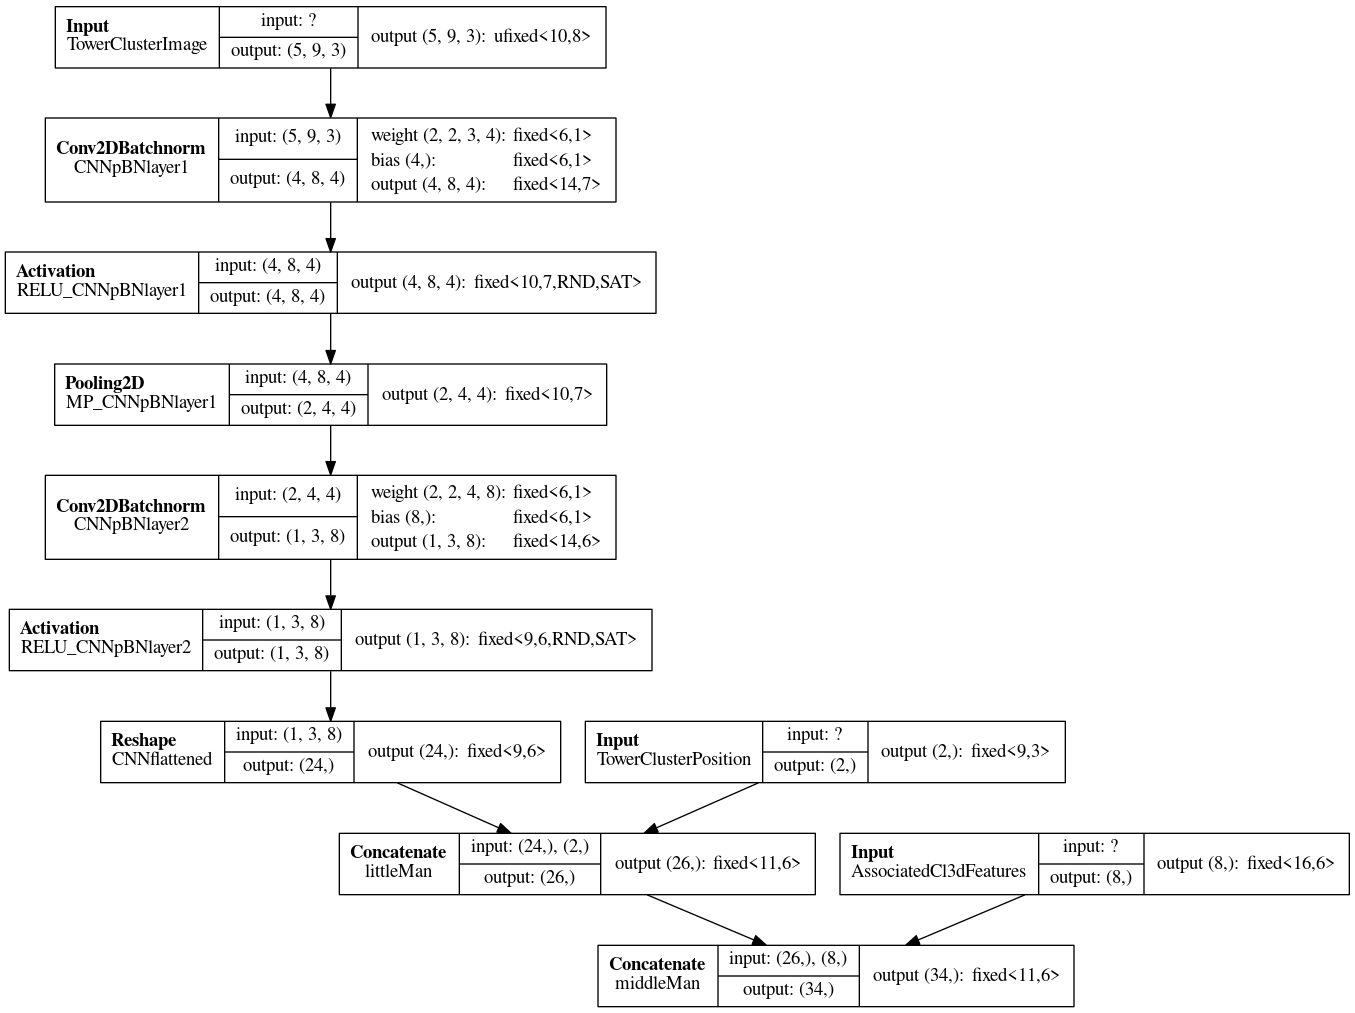

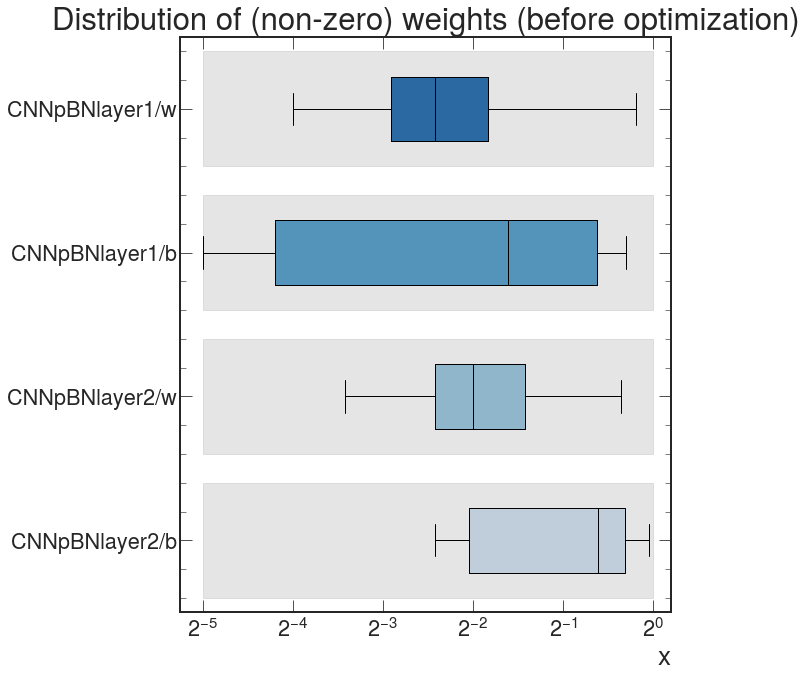

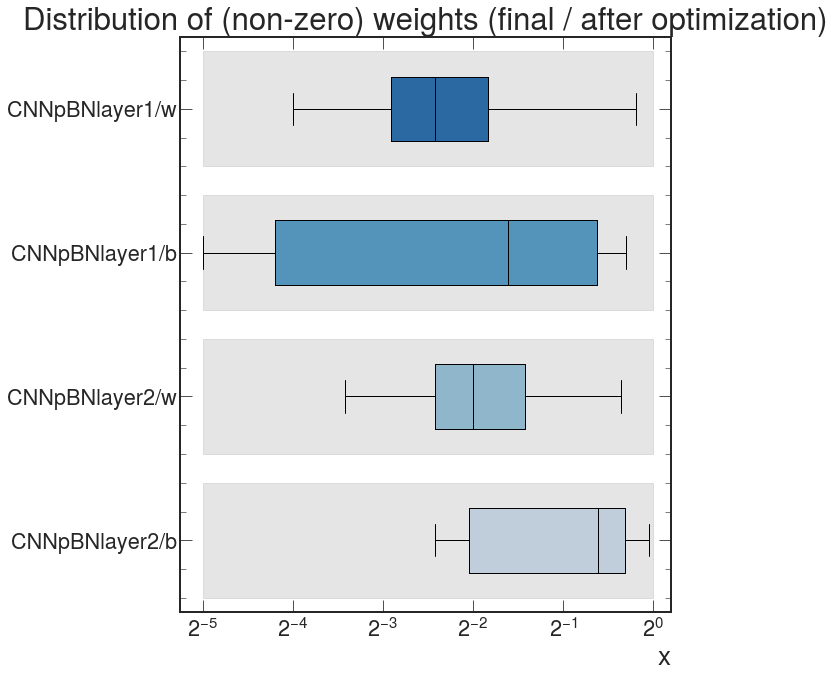

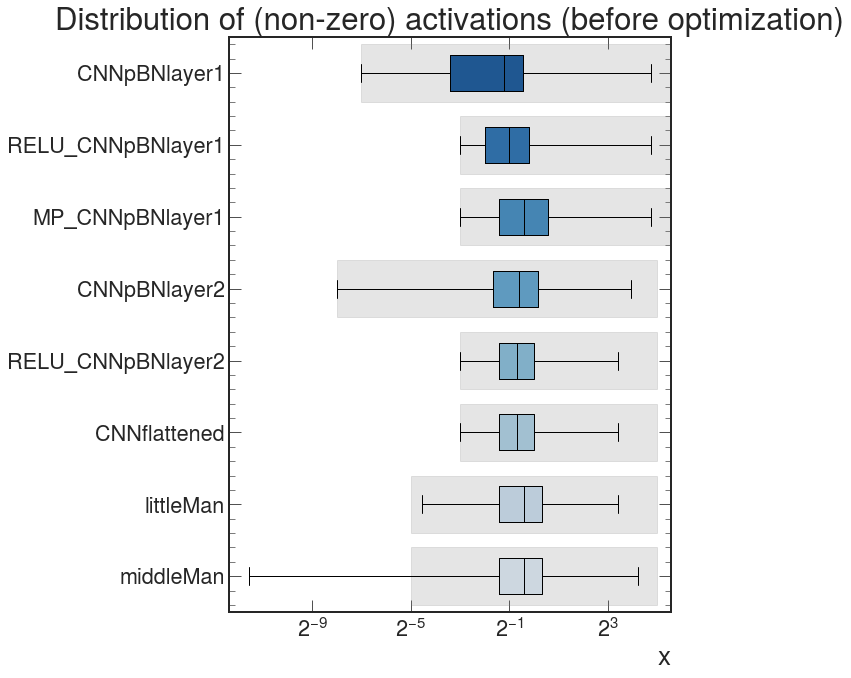

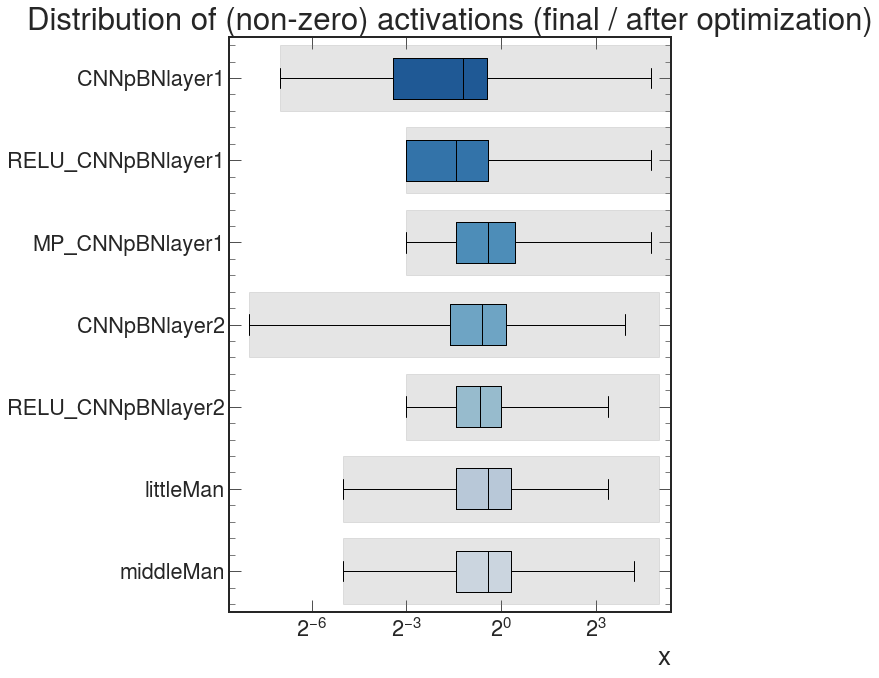

In [7]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_ufixed<10,8>'
QCNN_hls_cfg['LayerName']['TowerClusterPosition']['Precision'] = 'ap_fixed<9,3>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['ParallelizationFactor'] = 4
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<14,7>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<14,7>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<10,7>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['MP_CNNpBNlayer1']['Precision'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<14,6>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<14,6>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<9,6>'

QCNN_hls_cfg['LayerName']['littleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['littleMan']['Strategy'] = 'Stable'

QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = indir+'/CNNmodel_HLS/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced,X3_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: IDlayer1, layer type: QDense
  -> Activation (linear), layer name: IDlayer1
Layer name: RELU_IDlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_IDlayer1
Layer name: IDlayer2, layer type: QDense
  -> Activation (linear), layer name: IDlayer2
Layer name: RELU_IDlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_IDlayer2
Layer name: IDout, layer type: QDense
  -> Activation (linear), layer name: IDout
Layer name: sigmoid_IDout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'IDlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<9,7>', 'accum': 'ap_fixed<13,6>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'IDlayer1_linear': {

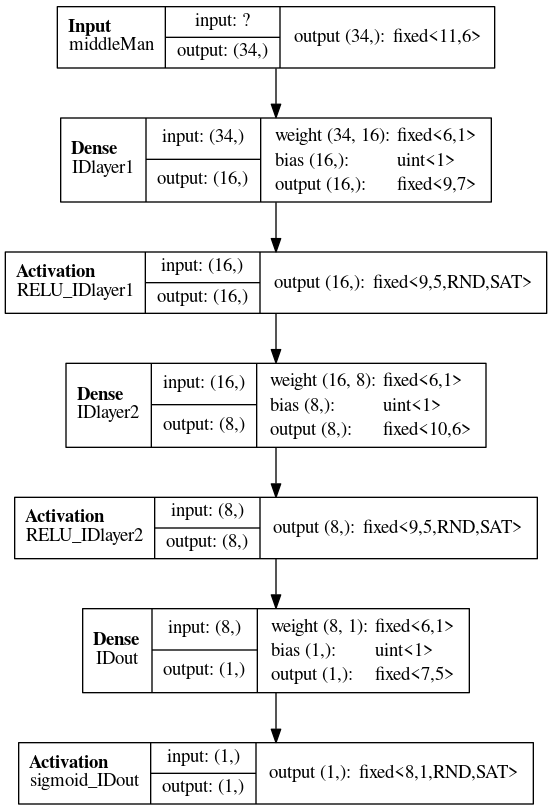

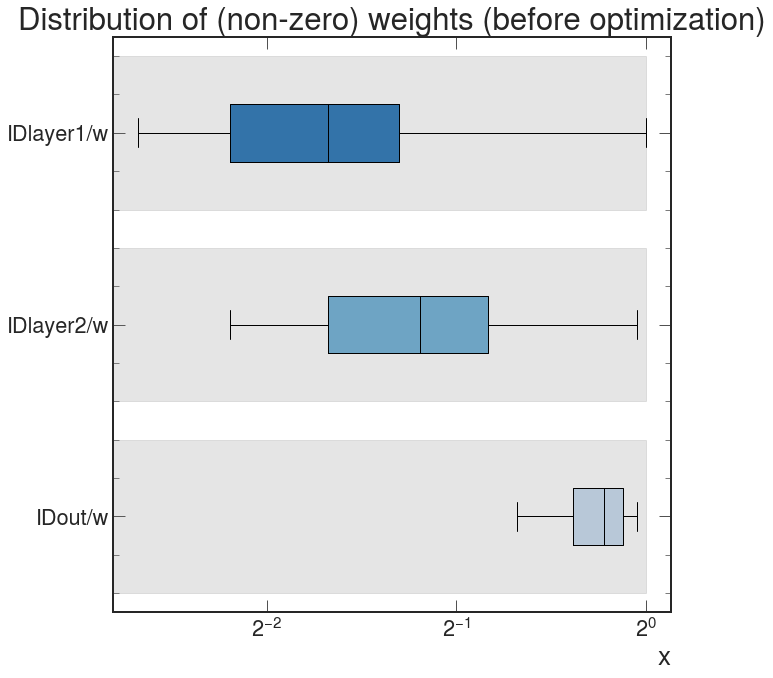

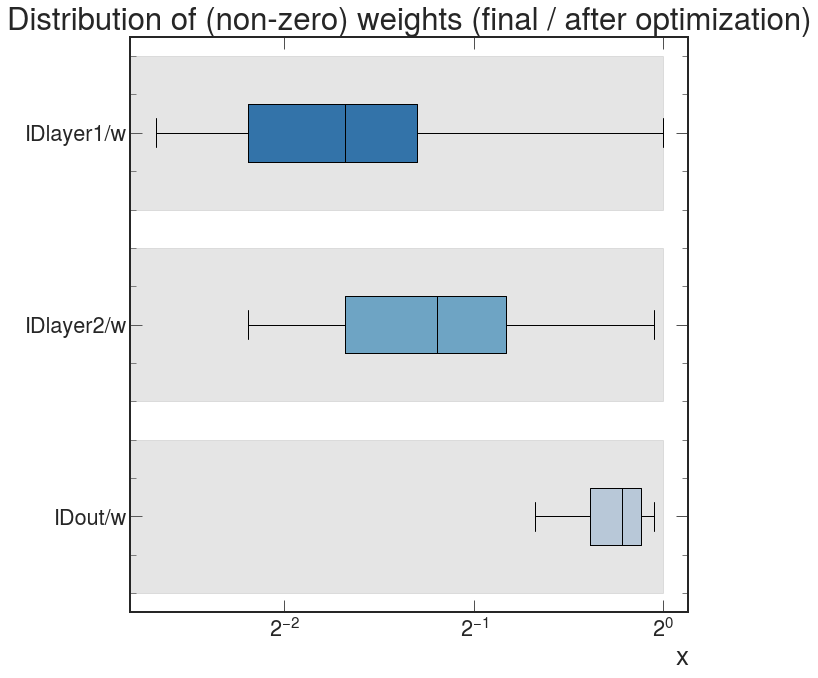

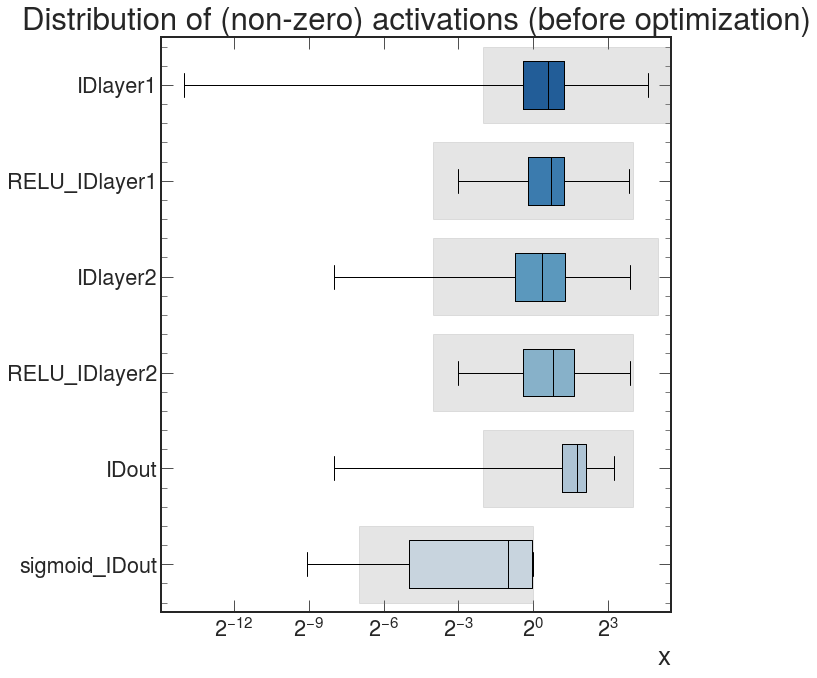

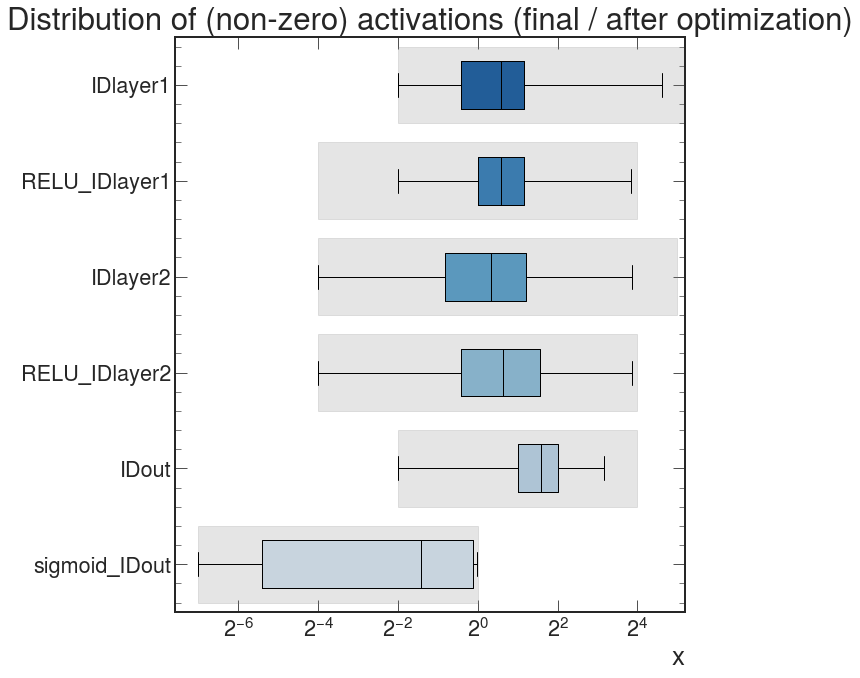

In [8]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    
id_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'

id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['result'] = 'ap_fixed<9,7>'
id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['accum'] = 'ap_fixed<13,6>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer1']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['result'] = 'ap_fixed<10,6>'
id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer2']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['result'] = 'ap_fixed<7,5>'
id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['accum'] = 'ap_fixed<7,5>'

id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_stream'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = indir+'/ID_DNNmodel_HLS/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced,X3_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: CALlayer1, layer type: QDense
  -> Activation (linear), layer name: CALlayer1
Layer name: RELU_CALlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer1
Layer name: CALlayer2, layer type: QDense
  -> Activation (linear), layer name: CALlayer2
Layer name: RELU_CALlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer2
Layer name: CALout, layer type: QDense
  -> Activation (linear), layer name: CALout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'CALlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<16,7>', 'accum': 'ap_fixed<16,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'CALlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'Reuse

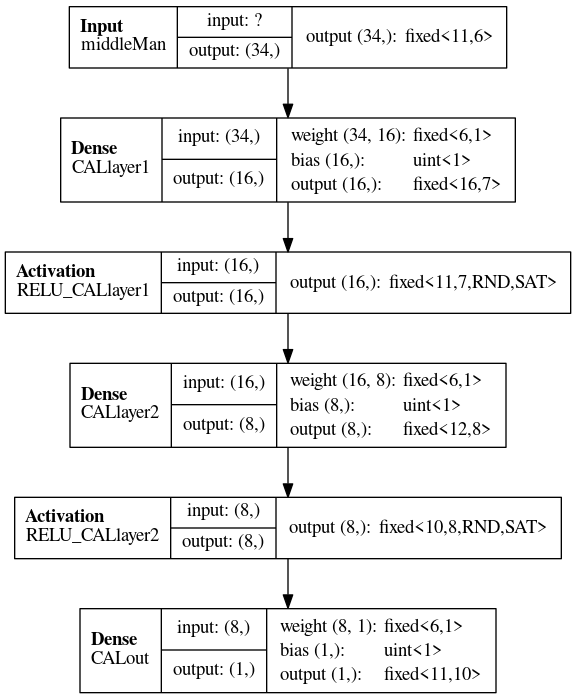

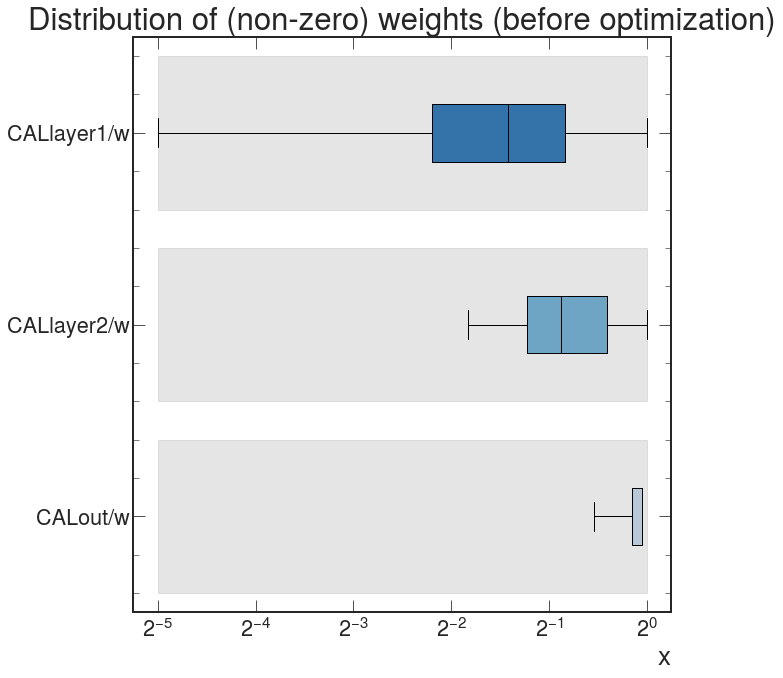

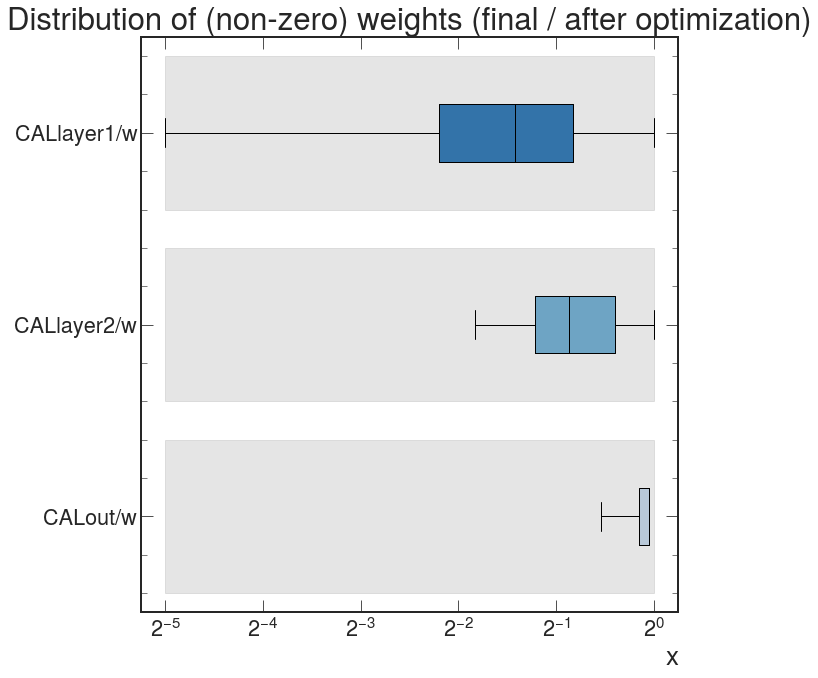

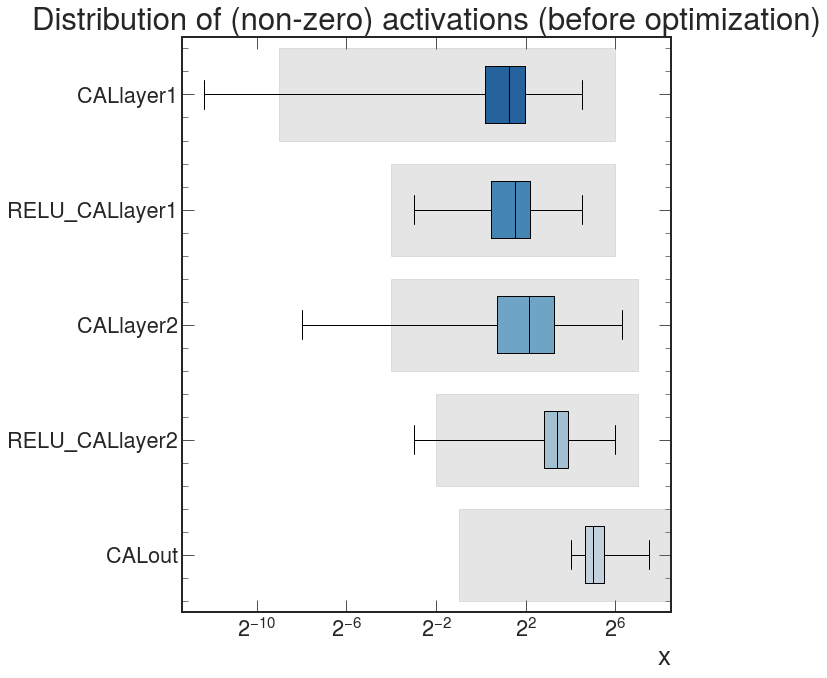

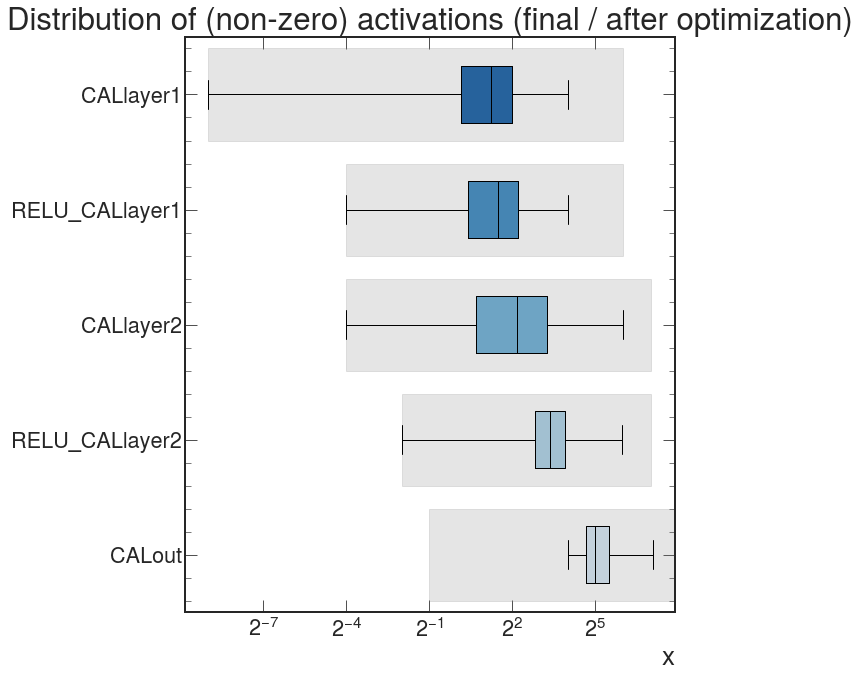

In [9]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'
    
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['result'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer2']['Precision'] = 'ap_fixed<10,8>'

cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['accum'] = 'ap_fixed<16,9>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = indir+'/CAL_DNNmodel_HLS/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced,X3_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [10]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Floating Point ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS Firmware ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=24)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

In [11]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1, X2, X3]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal, X3_cal]))

In [12]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1, X2, X3]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1, X2, X3]))

In [13]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal, X3_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal, X3_cal]))

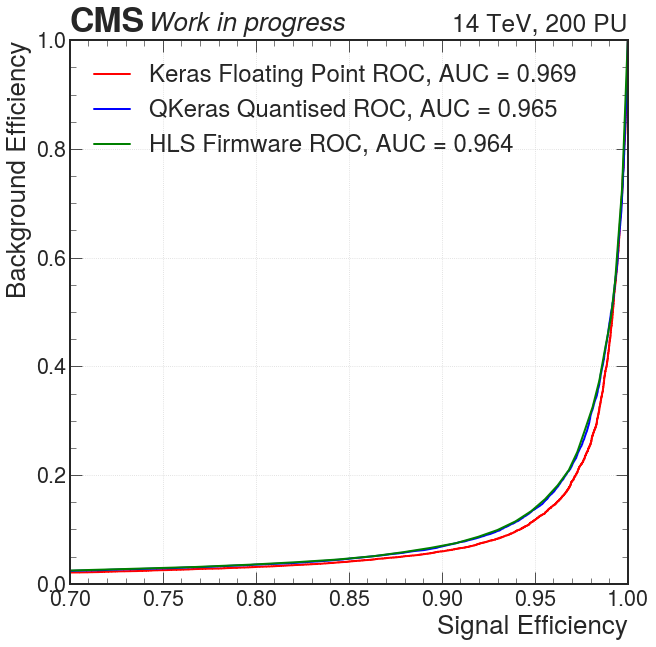

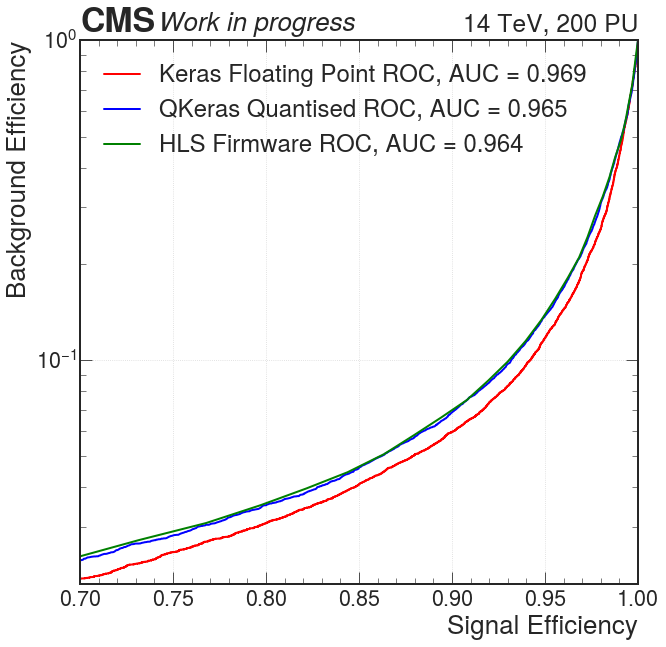

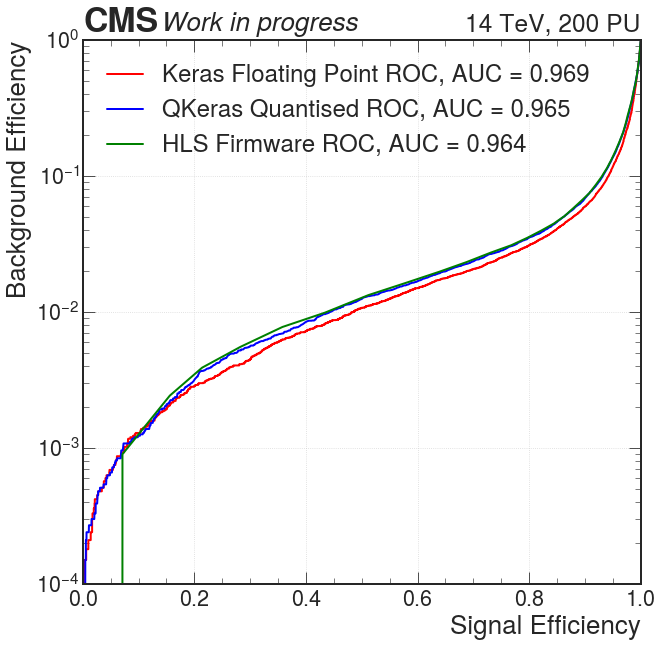

In [14]:
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [15]:
ravelled = Ycal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in progress'))

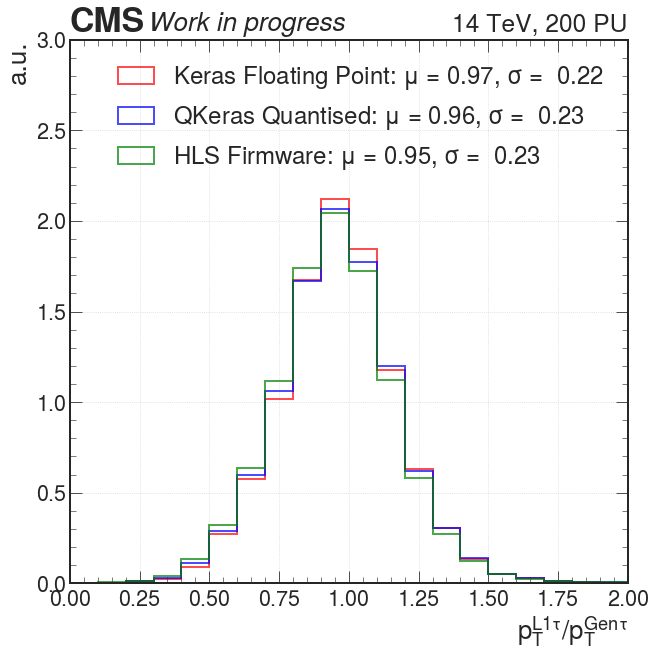

In [16]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Floating Point: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Quantised: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Firmware: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=24)
plt.grid(linestyle='dotted')
mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE HLS MODELS

In [17]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)

In [18]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)

In [19]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)